<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognition
Harrison Henningsen (he/him)

[Portfolio](https://internetweb.site/portfolio)

[LinkedIn](https://www.linkedin.com/in/hi-im-harrison/)

# Setup

We will explore digit classification using PyTorch and the MNIST dataset.

## Libraries

In [1]:
import numpy as np
import pandas as pd

from statsmodels.stats.proportion import proportions_chisquare, proportions_ztest
from sklearn.metrics import confusion_matrix, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

import torchvision

In [2]:
# set plotting theme with blank grids
sns.set_theme(rc={'grid.linestyle':''})

In [3]:
# for documentation reference
torch.__version__

'1.13.1+cu116'

## Set environment params

For repeatability of results, we fix a random seed.

In [4]:
# set random seed
torch.manual_seed(57)

In [5]:
# set batch sizes
batch_train=64
batch_test=1000

## CUDA Setup

In [6]:
# CUDA version
torch.version.cuda

'11.6'

In [7]:
(dev:=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

device(type='cuda')

We check that CUDA is available. We use the device flag `dev` later to marshal tensors and models to the GPU.

## Data

In [8]:
# define transformation sequence
transformations=[
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.1307,), # MNIST global mean
        (0.3081) # MNIST global std dev
    )
]

[From MNIST training mean and standard deviation.](https://datascience.stackexchange.com/questions/46228/how-mean-and-deviation-come-out-with-mnist-dataset)

In [9]:
# source MNIST data
data_train=torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(transformations)
)

data_test=torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(transformations)
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# define training data
train_loader=DataLoader(
    dataset=data_train,
    batch_size=batch_train,
    shuffle=True
)

# define test data

test_loader=DataLoader(
    dataset=data_test,
    batch_size=batch_test,
    shuffle=True
)

We download the MNIST data, convert to tensors and normalize, and define our data loaders. Recall that the training batch size is 64 and the testing batch size is 1000.

# Data Exploration

In [11]:
# get a batch
imgs,labels=next(iter(train_loader))

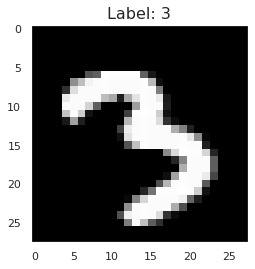

In [78]:
plt.figure(figsize=(4,4))
plt.title(f'Label: {labels[0]}',fontsize=16)
plt.imshow(imgs[0].squeeze(),cmap='gray');

Each record is a $28\times 28$ grayscale image with a corresponding label.

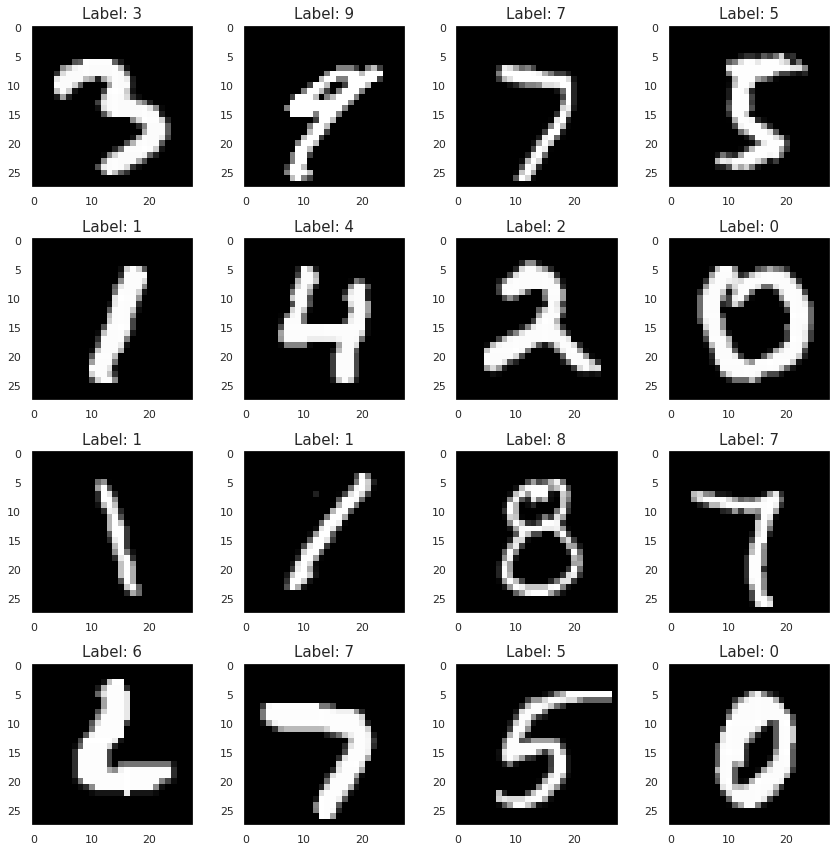

In [14]:
# plot samples
fig,ax=plt.subplots(4,4,figsize=(12,12))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.title(f'Label: {labels[i]}',fontsize=15)
  plt.imshow(imgs[i].squeeze(),cmap='gray')
fig.tight_layout()
plt.show()

Some entries are more legible than others. There is a good variety of orintations too.

## Imbalance

To investigate potential imbalance, we collect all labels in the training set.

In [15]:
labels_full=pd.Series([data_train[i][1] for i in range(60000)])

In [16]:
labels_full.value_counts().sort_values()

5    5421
4    5842
8    5851
6    5918
0    5923
9    5949
2    5958
3    6131
7    6265
1    6742
dtype: int64

There is certainly some imbalance. Label frequency ranges from 5421/60000 (label 5) to 6742/60000 (label 1). Note that a perfectly balanced dataset would have 6000 entries for each of the 10 classes. Visually:

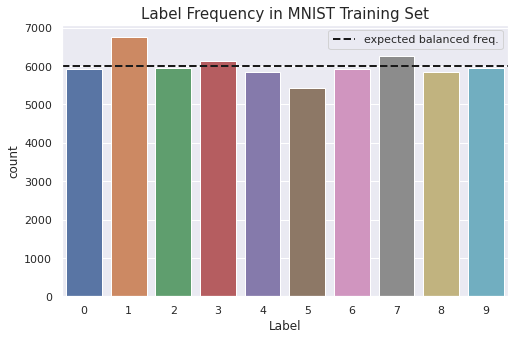

In [17]:
with sns.axes_style(rc={'grid.linestyle':'-'}):
  plt.figure(figsize=(8,5))
  plt.title('Label Frequency in MNIST Training Set',fontsize=15)
  sns.countplot(x=labels_full)
  plt.axhline(
      y=6000,
      color='k',
      linestyle='--',
      linewidth=2,
      label='expected balanced freq.')
  plt.xlabel('Label')
  plt.legend();

We see that classes 1 and 5 deviate appreciably from 6000. The question is: Assuming a level of significance of 5%, is there evedence that these classes are _truly_ imbalanced.

We perform a chi-squared test of proportions. The true value against which our frequencies will be measured is 0.1 (or 10%). A p-value less than 0.05 indicates that there is true deviation in at least one class from this 10% figure.

In [18]:
# chi-squared test for dataset balance inquiry
freqs=labels_full.value_counts().tolist()
train_nobs=[60000 for i in range(10)]

_,pval,(_,_)=proportions_chisquare(
    count=freqs,
    nobs=train_nobs,
    value=0.1
)

print(f'''With a p-value of {pval}, we can conclude
that there is imbalance in the MNIST dataset.''')

With a p-value of 7.124517413614377e-36, we can conclude
that there is imbalance in the MNIST dataset.


Indeed, there is statistically significant imbalance in our dataset. Using now a two-proportions z-test, we can determine which classes skew too far from 10% representation.

Once more, we assume a level of significance of 5%. Our null hypothesis is that there is no statistical difference between the frequency of a particular class and the balanced 6000/60000. The alternate hypothesis is that the class frequency does indeed deviate.

In [20]:
# two-proportions z-test for each digit
pval_dict={}
for key in (label_dict:=labels_full.value_counts().to_dict()):
  _,pval=proportions_ztest(
      count=[label_dict[key],6000],
      nobs=[60000,60000]
  )
  pval_dict[key]=pval

# print results, annotate rejections
for digit,pval in enumerate(pd.Series(pval_dict).sort_index()):
  status=('reject' if pval<0.05 else 'fail to reject')
  annot=('*' if pval<0.05 else ' ')
  print(f'''{annot+str(digit)}: We {status} the null hypothesis
  with a p-value of {pval}.\n''')

 0: We fail to reject the null hypothesis
  with a p-value of 0.4574473727151762.

*1: We reject the null hypothesis
  with a p-value of 3.580597236007005e-12.

 2: We fail to reject the null hypothesis
  with a p-value of 0.6856424615469848.

 3: We fail to reject the null hypothesis
  with a p-value of 0.209665965204355.

 4: We fail to reject the null hypothesis
  with a p-value of 0.1261785990783033.

*5: We reject the null hypothesis
  with a p-value of 1.2289419334341624e-08.

 6: We fail to reject the null hypothesis
  with a p-value of 0.4286786623656247.

*7: We reject the null hypothesis
  with a p-value of 0.011557788056848121.

 8: We fail to reject the null hypothesis
  with a p-value of 0.1493746194861904.

 9: We fail to reject the null hypothesis
  with a p-value of 0.6229471156193913.



Those classes that deviate (p-value < 0.05) are annotated with an astrisk. Along with 1, we find that 7 is also appreciably overrepresented. And while 4 and 8 are somewhat underrepresented, their p-values are slightly too high to be considered definitively imbalanced. Accordingly, 5 is the only appreciably underrepresented class.

# Building a Fully-Connected Neural Network


In [21]:
class DigitClfr(nn.Module):

  def __init__(self):
    super(DigitClfr,self).__init__()
    self.Linear1=nn.Linear(28**2,1024)
    self.Linear2=nn.Linear(1024,256)
    self.Linear3=nn.Linear(256,64)
    self.Linear4=nn.Linear(64,10)

  def forward(self,x):
    x=x.view(-1,28**2)
    x=F.relu(self.Linear1(x))
    x=F.relu(self.Linear2(x))
    x=F.relu(self.Linear3(x))
    x=self.Linear4(x)
    return x.squeeze()

We begin by defining our network as a class. It inherits properties of the superclass `torch.nn.Module`.

Our network as four layers. 

In [48]:
# initialize network
nwk=DigitClfr().to(dev)

# loss function
L=nn.CrossEntropyLoss()

# optimizer
opt=SGD(nwk.parameters(),lr=0.01)

## Testing Forward Pass

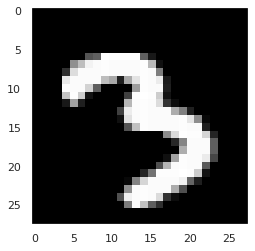

In [23]:
# input image
plt.imshow(imgs[0].squeeze(),cmap='gray');

In [24]:
# probability density function tensor 
# containing (currently random) predictions
(test_out:=nwk(imgs[0].squeeze().to(dev)))

tensor([-0.0349,  0.0862, -0.0684, -0.0928,  0.1223,  0.0380, -0.1017,  0.0375,
        -0.0797, -0.0825], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [25]:
test_out.shape

torch.Size([10])

Output tensor shape is correct. We get 10 probabilities: one for each digit label.

In [37]:
# cross entropy loss
L(test_out,labels[0].to(dev)).item()

2.3807878494262695

## Training

In [49]:
epochs,losses=[],[]
test_avg_losses=[]
load_len=len(train_loader)

In [47]:
!mkdir training_results

def train_epoch(epoch_id):
  print(f'Epoch {epoch_id} Training')
  for batch_id,(x,y) in enumerate(train_loader):
    x,y=x.to(dev),y.to(dev)

    # loss calculation and back propagation
    opt.zero_grad()
    loss=L(nwk(x),y)
    loss.backward()
    opt.step()
    
    # record losses by (partial) epoch
    epochs.append(epoch_id+batch_id/load_len)
    losses.append(loss.item())

    # print progress
    if batch_id%100==0:
      p=100*(batch_id/load_len)
      print(f'{int(p)}% completed with loss {np.round(loss.item(),4)}')

  # save internal state
  torch.save(nwk.state_dict(),'./training_results/network.pth')
  torch.save(opt.state_dict(),'./training_results/optimizer.pth')

  return

In [40]:
def test():
  total_loss,num_correct=0,0

  with torch.no_grad():
    for x,y in test_loader:
      x,y=x.to(dev),y.to(dev)
      out=nwk(x)
      total_loss+=L(out,y).item()
      y_hat=out.max(dim=1,keepdim=True)[1]
      num_correct+=y_hat.eq(y.view_as(y_hat)).sum()

  test_avg_losses.append(w:=total_loss/len(test_loader))
  print(f'avg loss: {w}')
  print(f'% correct: {100*num_correct/len(test_loader.dataset)}')
  return total_loss,num_correct

In [50]:
test()
print('='*50)
for i in range(1,6):
  train_epoch(i)
  print('='*50)
  test()
  print('='*50)

avg loss: 2.3075052738189696
% correct: 8.609999656677246
Epoch 1 Training
0% completed with loss 2.3191
10% completed with loss 2.2068
21% completed with loss 1.9329
31% completed with loss 1.2666
42% completed with loss 0.7821
53% completed with loss 0.6531
63% completed with loss 0.438
74% completed with loss 0.461
85% completed with loss 0.4205
95% completed with loss 0.416
avg loss: 0.3651804059743881
% correct: 89.13999938964844
Epoch 2 Training
0% completed with loss 0.5074
10% completed with loss 0.454
21% completed with loss 0.3543
31% completed with loss 0.3178
42% completed with loss 0.2857
53% completed with loss 0.3893
63% completed with loss 0.4173
74% completed with loss 0.3641
85% completed with loss 0.2728
95% completed with loss 0.1572
avg loss: 0.2591382309794426
% correct: 92.54000091552734
Epoch 3 Training
0% completed with loss 0.3665
10% completed with loss 0.159
21% completed with loss 0.239
31% completed with loss 0.265
42% completed with loss 0.1698
53% comple

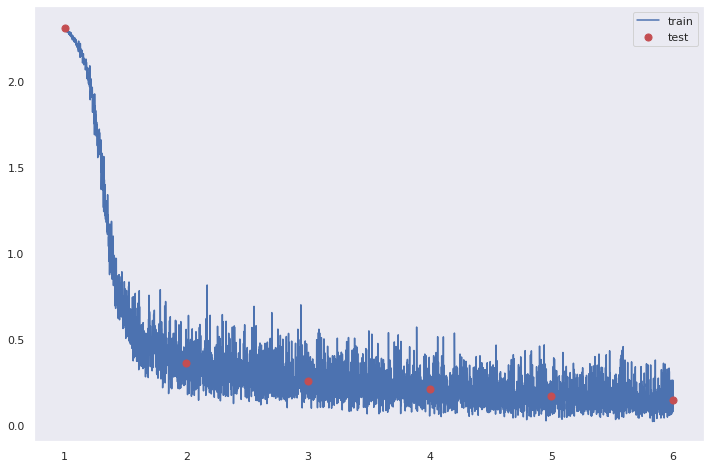

In [52]:
plt.figure(figsize=(12,8))
plt.plot(
    epochs,
    losses,
    label='train',
    zorder=0
)
plt.scatter(
    x=np.arange(1,7),
    y=test_avg_losses,
    c='r',
    s=50,
    label='test'
)
plt.legend()
plt.show()

In [66]:
def cm(dl):
  '''Generate a confusion matrix of
  NN results for a given data loader.'''

  y_pred=[]
  y_true=[]

  for x,y in dl:
    x=x.to(dev)
    y_pred.extend(nwk(x).max(dim=1)[1].cpu().numpy())
    y_true.extend(y)

  cmat=confusion_matrix(
      y_true,
      y_pred,
      labels=np.arange(10)
  )

  acc=accuracy_score(y_true,y_pred)
  return cmat,acc

In [68]:
cmat,acc=cm(train_loader)

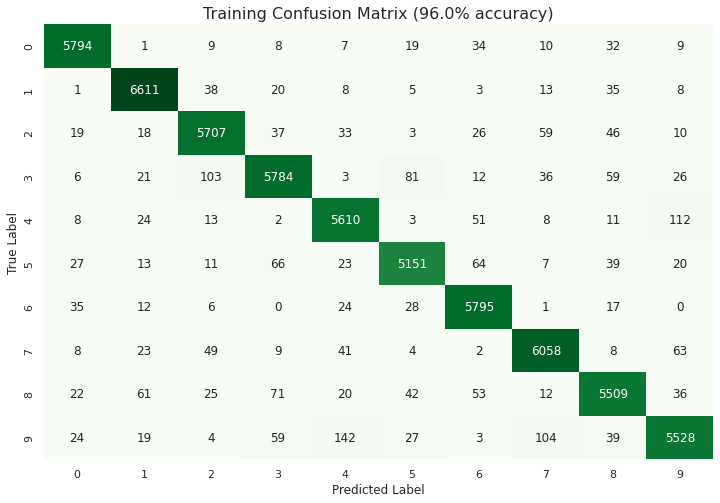

In [72]:
plt.figure(figsize=(12,8))
plt.title(f'Training Confusion Matrix ({100*np.round(acc,2)}% accuracy)',fontsize=16)
sns.heatmap(
    data=cmat,
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt='g'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [73]:
cmat,acc=cm(test_loader)

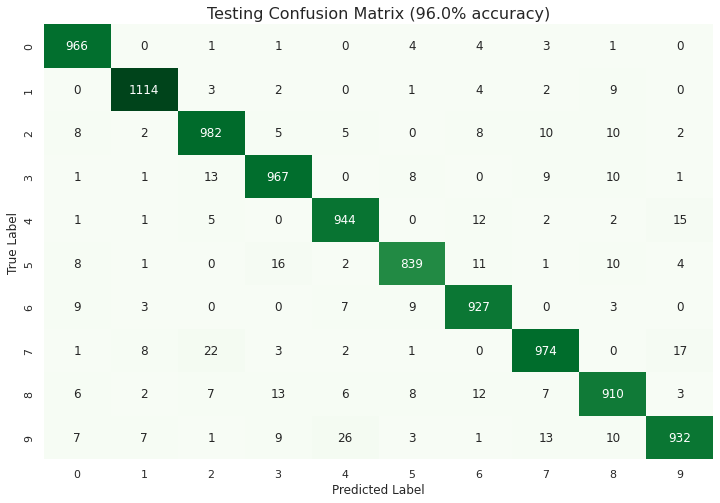

In [74]:
plt.figure(figsize=(12,8))
plt.title(f'Testing Confusion Matrix ({100*np.round(acc,2)}% accuracy)',fontsize=16)
sns.heatmap(
    data=cmat,
    cmap='Greens',
    cbar=False,
    annot=True,
    fmt='g'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()